## The Impact of Intermediate Dimensionality on the Clustering Coherence of News Embeddings using HDBSCAN
---
This notebook evaluates clustering pipelines for news article embeddings by systematically varying intermediate dimensionality reduction and measuring cluster coherence, coverage, and stability. We show that clustering quality is highly sensitive to the reduced dimension and that stable, interpretable trends emerge only within a narrow range of pipeline configurations.

In [17]:
# Standard Library
import uuid
import ast
import itertools

# Data Handling & Science
import pandas as pd
import numpy as np

# Dimensionality & Clustering
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA
import umap
import hdbscan

# Metrics
from sklearn.metrics import adjusted_rand_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Misc
import warnings
warnings.filterwarnings('ignore', message='.*n_jobs value 1 overridden.*')

seed:int = 67

### Introduction
---
Recent progress in transformer-based language models has made it straightforward to represent large collections of text as high-dimensional semantic embeddings. Because these embeddings are often massive (over 3,000 dimensions), we rarely cluster them directly. Instead, we use "intermediate" steps to shrink the data down before grouping it.

Why do we do this? Direct clustering in high dimension is hindered by _distance concentration_. Geometrically, as dimensionality increases, the contrast between the distance to the nearest and farthest neighbors diminishes. Density-based algorithms like [HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) identifies clusters by evaluating the distance and connectivity of a Minimum Spanning Tree. This 'flatness' in distance prevents the algorithm from distinguishing between dense topical cores and the sparse background noise. Intermediate dimensionality reduction serves to __restore the local density contrast__ necessary for HDBSCAN’s reachability metrics to function.

In most data pipelines, developers use Principal Component Analysis (PCA) or Uniform Manifold Approximation and Projection (UMAP) to handle this shrinkage. While PCA is a classic, linear approach that focuses on broad patterns, UMAP is a modern, non-linear method designed to keep related items close together. However, after searching for a 'best' intermediate dimension, most sources pointed to heuristics.

This choice is especially important for Hierarchical Density-Based Spatial Clustering of Applications with Noise(HDBSCAN), a clustering algorithm that groups data based on how "dense" it is. Because the very concept of "density" changes depending on how many dimensions you have, the intermediate step isn't just a technicality—it might completely change which news stories get grouped together and which are thrown out as "noise."

### The Goal
---
I'm particularly intrested in using HDBSCAN for automating trend detection in news for a digestive reading app called SightRead. Through this project I hope to learn more about the tradeoffs in choosing a clustering pipeline, and simply document findings. 

In this work, I explore how changing the number of intermediate dimensions for both PCA and UMAP affects the final quality of news clusters. By testing a range of dimensions, I aim to measure:

__Cluster Coherence__: How semantically similar are the articles within a single group?

__Noise Levels__: How much of our data is discarded as "un-clusterable" in different dimensions?

__Method Comparison__: Does UMAP’s non-linear approach actually produce better clusters for news than the simpler PCA method?

By analyzing embeddings from RSS news feeds, I hope to provide a practical guide for which dimensionality reduction settings actually work best for organizing the daily news.

### An Overview of Data Collection
---
I'll give a quick overview of where and how the data is collected, more information on the dataset can be found [here](https://github.com/evansun06/trend-analysis-sr/blob/main/wrangling.ipynb). Articles were polled for a 1-week window from January 5th to January 12th from a select subset of RSS feeds from _The Guardian_, _The Wall Street Journal_, _United Nations_, _Fox News_, and _Daily Mail_.

<p align="center">
	<img src="assets/rss_aggregation.png" alt="Data aggregation diagram" width="720" />
</p>

_figure: SightRead RSS aggregation workflow_



### Dataset overview

__Fields__ (post-wrangling):
1. article_id: UUID for a unique article.
2. normalized_text: Headline concatenated with description, normalized.
3. polled_at: timestamp when the article was polled at (each RSS feed was polled by the hour)
4. published_at: the publication date of the article for possible time series analysis
5. embedding: the embedding vector (OpenAI text-embedding-3-large)

*_see `wrangling.ipynb` for wrangling procedures_

In [2]:
df = pd.read_csv("data/wrangled_articles.csv")
df.head()

,article_id,normalized_text,polled_at,published_at,embedding
0,d9509dc9-a405-4866-9201-19e3d063d137,Outrage as 'miserable' shovel-wielding neighbo...,2026-01-07 13:33:24.714064+00,2026-01-07 13:29:24+00,"[-0.011435215,-0.03746951,-0.0075333593,-0.026..."
1,9a156ce2-11d6-4eff-b243-e2d2bb208faa,"Morality, military might and a sense of mischi...",2026-01-09 05:17:56.535446+00,2026-01-09 03:15:08+00,"[0.0061512175,-0.03799464,-0.016263446,-0.0129..."
2,df3b2fc9-4d0f-4199-bca1-ea6d954e0c31,Republican senator vows to block all Fed nomin...,2026-01-12 15:17:02.967673+00,2026-01-12 14:55:53+00,"[-0.0072780806,-0.023142586,-0.021380594,0.020..."
3,d0f6077e-15be-497e-9a2b-1c023486ce9a,Starmer prepares to rip up Brexit: PM ready to...,2026-01-05 04:42:39.19293+00,2026-01-04 15:49:23+00,"[0.018081628,0.02099675,-0.010544334,0.0247128..."
4,847a6cef-0c95-4a0f-9388-7345ba01bf26,ANOTHER poll shows Labour in third behind Refo...,2026-01-07 11:12:56.5161+00,2026-01-07 10:57:35+00,"[0.032669835,-0.002811013,-0.012023548,-0.0104..."


## Part I: The Effect of Intermediate Dimensionality on the Cluster Quality of HDBSCAN with respect to PCA and UMAP

The goal: In this section we'll explore and compare the effect of clustering with HDBSCAN in an particular intermediate dimension, $d$, on cluster coherence. We'll observe the effect under two pipelines which use UMAP and PCA to reduce dimensionality, respectively.


Let us first define our embedding data mathematically:

Let $N$ be the number of news articles contained in the dataset. Each article $i$ is represented by an embedding vector where $D$ is the embedding space (3072).

$$
x_i \in \mathbb{R}^D
$$



We stack embeddings into a matrix $X \in \mathbb{R}^{D\times N}$ where

$$

X = \begin{bmatrix} x_1^{\top} \\ x_2^{\top} \\ \vdots \\ x_N^{\top}\end{bmatrix} \in \mathbb{R}^{N \times D}

$$

In [3]:
# Stack raw embeddings into D x N numpy matrix
df['embedding'] = df['embedding'].apply(ast.literal_eval)
X_raw = np.vstack(df['embedding'].values)

# L2 Normalize
X_norm = Normalizer(norm='l2').fit_transform(X_raw)

# Append original dataset for later reference
df['embedding_norm'] = list(X_norm)

Below we define the two clustering piplines

__Pipeline A: Unifold Manifold Approximation with Projection__

1. L2 Normalization (scikit-learn)

$$\hat{X} = \{ \hat{x}_1, \hat{x}_2, \dots, \hat{x}_n \}^\top \quad \text{where} \quad \hat{x}_i = \frac{x_i}{\|x_i\|_2}$$

2. Reduce to intermediate dimension via PCA
$$
    {PCA}_{(d)}: \mathbb{R}^D \rightarrow \mathbb{R}^d
$$

$$
    \hat{X} \rightarrow Z^{(pca)}_d,\ \ \  Z^{(pca)}_d\in \mathbb{R}^{N \times d}
$$

3. Cluster using HDBSCAN with variated hyperparameters
    - `min_cluster_size`
    - `min_samples`
    - `output`: Assigns each article $i$ with label $\ell_i \in \{-1, 0, 1, ..., K-1\}$ where -1 is noise


__Pipeline B: Principle Component Analysis__

_Repeat with UMAP_
$$
{UMAP}_{(d)}: \mathbb{R}^D \rightarrow \mathbb{R}^d
$$

$$
    \hat{X} \rightarrow Z^{(umap)}_d,\ \ \  Z^{(umap)}_d\in \mathbb{R}^{N \times d}
$$

In [4]:
### Pipeline Helper Implemntation

def cluster_hdbscan(mcs: int, ms: int, Z):
    """
    Use HDBSCAN to clusters the reduced embeddings

    args: 
        - mcs: minimum cluster size
        - ms: minimum samples
        - Z: the reduced embeddings matrix
    
    returns:
        - labels: {-1, 0, ..., K - 1}
    """

    clusterer = hdbscan.HDBSCAN(
        min_cluster_size= mcs,
        min_samples= ms,
        metric="euclidean"
    )   

    return clusterer.fit_predict(Z)


def reduce_umap(d: int, X_hat):
    """
    Reduce embedding matrix to desired intermediate space via UMAP

    args: 
        - d: intermediate dimension
        - X_hat: normalized embeddings in original space

    returns:
        - Z_umap: matrix containing the reduced embeddings
    """

    # UMAP config for clustering (Heuristic Heavy)
    reducer = umap.UMAP(
        n_components=d, 
        n_neighbors=30,
        min_dist=0.0, 
        metric="cosine", 
        random_state=seed,
        n_jobs=-1
    )

    return reducer.fit_transform(X_hat)
    

def reduce_pca(d: int, X_hat):
    """
    Reduce embedding matrix to desired intermediate space via PCA

    args: 
        - d: intermediate dimension
        - X_hat: normalized embeddings in original space

    returns:
        - Z_pca: matrix containing the reduced embeddings
    """
    
    reducer = PCA(
        n_components=d,
        random_state=seed
    )

    return reducer.fit_transform(X_hat)


### Variables

__Pipeline configurations__ $(d, {mcs}, {ms})$:
- intermediate dimension $d \in \{2, 3, 5, 10, 15, 25, 35, 50, 75, 100, 500\}$
    - covers a range of interesting dimensions including heuristic sweetspots (10-50) and pitfall ranges (100+)
- min_cluster_size(mcs): HDBSCAN hyperparameter $\{5, 10, 25, 50\}$
    - minimum size HDBSCAN will consider a legitimate, independent cluster rather than noise
- min_samples(ms): HDBSCAN hyperparameter $\{1, 5, 15, 30\}$
    - defines how many neighbors a point must have to be considered a "core" part of a dense region

We'll compare a grid of min_cluster_size and min_samples as these hyperparameters are highly effected by dimensionality

In [5]:
d_values = [2, 3, 5, 10, 15, 25, 35, 50, 75, 100, 500]
mcs_values = [5, 10, 25, 50]
ms_values = [1, 5, 15, 30]

With context and setup in place! Lets get some results!

In [53]:
all_results = []
article_ids = df['article_id'].values 

for pipeline_name, reducer_func in [('UMAP', reduce_umap), ('PCA', reduce_pca)]:

    for d in d_values:
        # Step 1: Reduce once per dimension d
        Z = reducer_func(d, X_norm)
        
        for mcs in mcs_values:
            for ms in ms_values:

                # Step 2: Cluster
                labels = cluster_hdbscan(mcs, ms, Z)
                
                # Create a temporary DataFrame for this specific run
                run_df = pd.DataFrame({
                    'article_id': article_ids,
                    'cluster_label': labels
                })
                
                # Assign the constants for this run
                run_df['pipeline'] = pipeline_name
                run_df['d'] = d
                run_df['mcs'] = mcs
                run_df['ms'] = ms
                
                all_results.append(run_df)

# Final squash: concat is very efficient for a list of DataFrames
results_df = pd.concat(all_results, ignore_index=True)

/Users/evansun/Desktop/sr/sr_data_analysis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/evansun/Desktop/sr/sr_data_analysis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/evansun/Desktop/sr/sr_data_analysis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/evansun/Desktop/sr/sr_data_analysis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/evansun/Desktop/sr/sr_data_analysis/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for p

In [20]:
# Temporary CSV read to reduce computation
results_df = pd.read_csv("data/grid_search_results.csv")
results_df.head(30)


,Unnamed: 0,article_id,cluster_label,pipeline,d,mcs,ms
0,0,d9509dc9-a405-4866-9201-19e3d063d137,217,UMAP,2,5,1
1,1,9a156ce2-11d6-4eff-b243-e2d2bb208faa,-1,UMAP,2,5,1
2,2,df3b2fc9-4d0f-4199-bca1-ea6d954e0c31,45,UMAP,2,5,1
3,3,d0f6077e-15be-497e-9a2b-1c023486ce9a,144,UMAP,2,5,1
4,4,847a6cef-0c95-4a0f-9388-7345ba01bf26,144,UMAP,2,5,1
5,5,a0e980c1-7972-415b-9801-4df8af1b051f,1,UMAP,2,5,1
6,6,cfad478c-a1f7-4587-95cb-9782b0c6efa2,-1,UMAP,2,5,1
7,7,4316d524-7d26-4f2f-a23a-41d8a0b930db,63,UMAP,2,5,1
8,8,0a108db8-aea5-430a-955f-09eb7038df40,98,UMAP,2,5,1
9,9,fa3897bf-3efd-4af7-84ba-2d4936f0478d,23,UMAP,2,5,1


### Clustering Verification

Before we dive deeper into metrics and analysis, lets get a visual confirmation of our clusters! On a whim i'll choose the configuration `(d = 50, mcs = 10, ms =5)` and hope they give us some cool early visuals!

In [18]:
### --- Obtain labels for each pipeline ---

umap_filtered = (
    results_df
    .query("d == 50 & mcs == 10 & ms == 5 & pipeline == 'UMAP'")
    .filter(items=['article_id', 'cluster_label'])
)

pca_filtered = (
    results_df
    .query("d == 50 & mcs == 10 & ms == 5 & pipeline == 'PCA'")
    .filter(items=['article_id', 'cluster_label'])
)

### --- Reduce to 2D with respective algorithms for visualization ---

umap_2d = umap.UMAP(
    n_components=2,
    n_neighbors=30,
    min_dist=0.1,
    metric="cosine",
    random_state=seed
)

pca_2d = PCA(
    n_components=2, 
    random_state=seed
)

Z_2d_umap = umap_2d.fit_transform(X_norm)
Z_2d_pca = pca_2d.fit_transform(X_norm)

test_visuals = pd.DataFrame({
    # Use .values to strip the index and treat it as a raw list
    'label_umap': umap_filtered['cluster_label'].values,
    'label_pca': pca_filtered['cluster_label'].values,
    'umap_x': Z_2d_umap[:, 0],
    'umap_y': Z_2d_umap[:, 1],
    'pca_x': Z_2d_pca[:, 0],
    'pca_y': Z_2d_pca[:, 1]
})

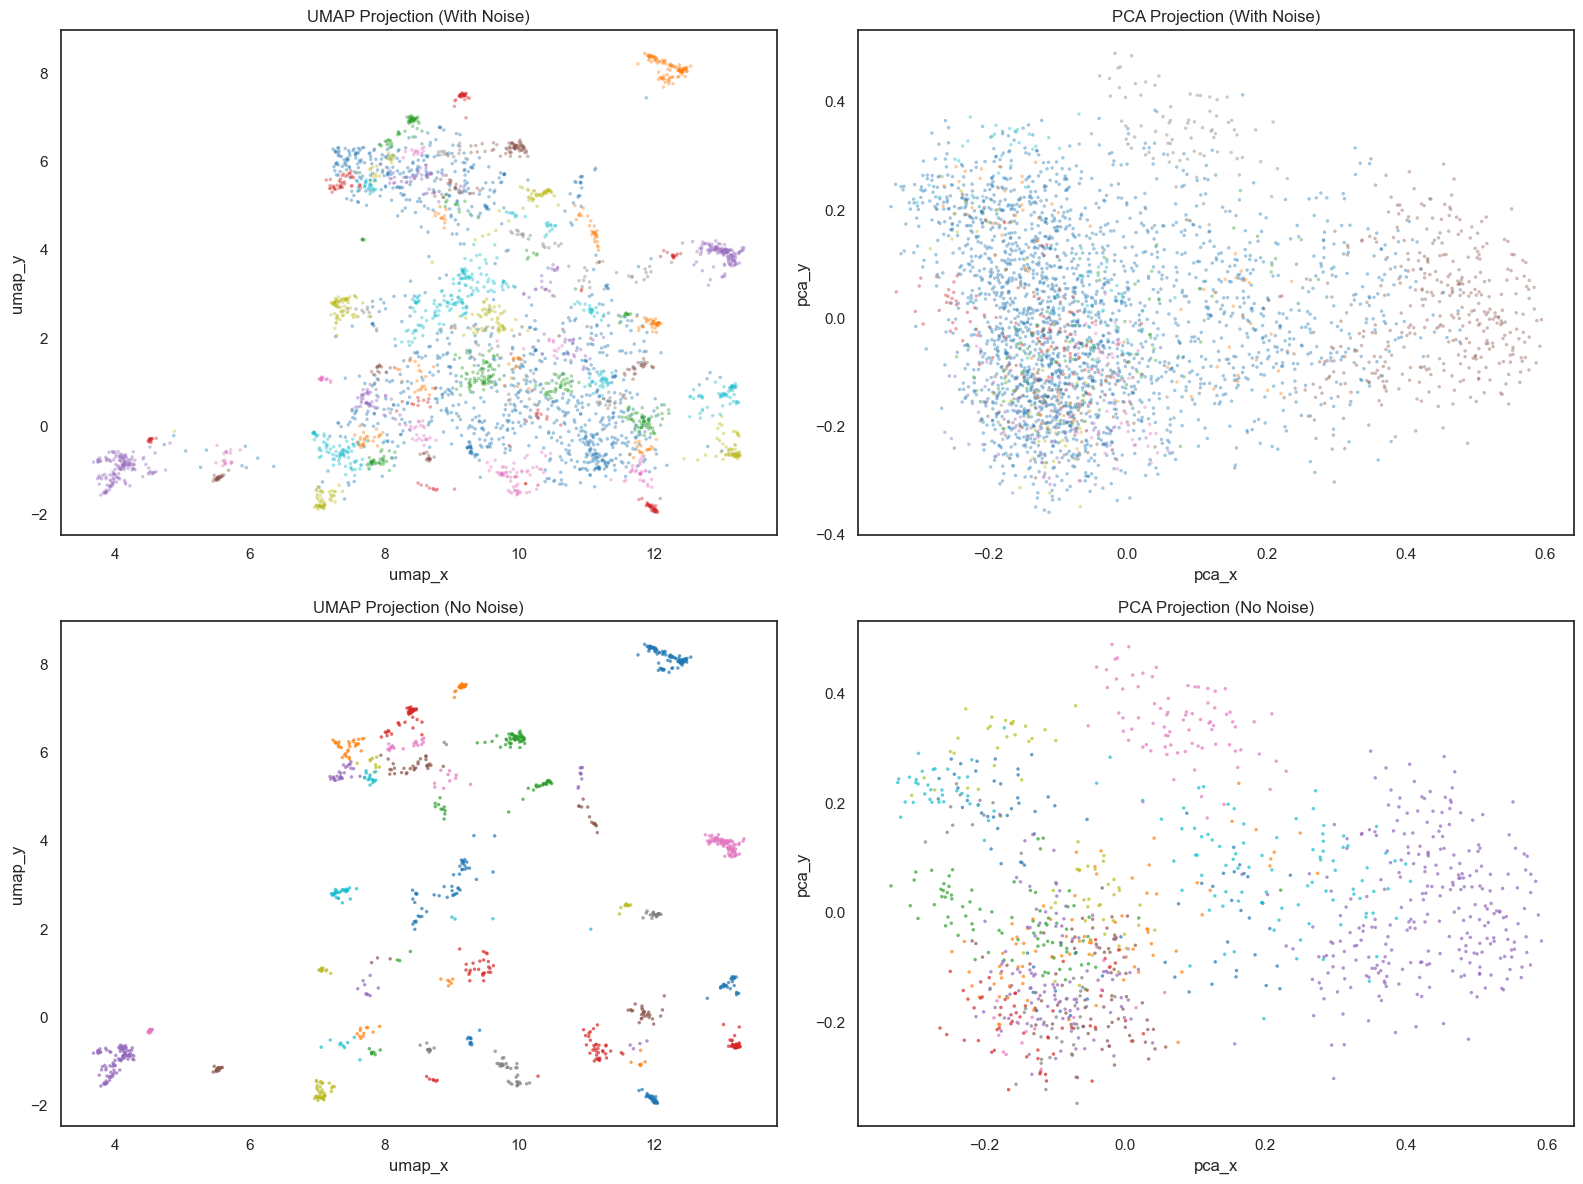

In [22]:
# 1. Prepare the data
# Create a string version for categorical plotting
test_visuals['label_umap'] = test_visuals['label_umap'].astype(str)
test_visuals['label_pca'] = test_visuals['label_pca'].astype(str)

# Create a filtered version for the "No Noise" row
# (Assuming '-1' is the string label for noise)
no_noise_df = test_visuals[
    (test_visuals['label_umap'] != '-1') & 
    (test_visuals['label_pca'] != '-1')
].copy()

sns.set_theme(style="white")
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- ROW 1: WITH NOISE ---

# Plot 1: UMAP with Noise
sns.scatterplot(
    ax=axes[0, 0], data=test_visuals.sort_values('label_umap'),
    x='umap_x', y='umap_y', hue='label_umap',
    palette='tab10', alpha=0.4, s=5, edgecolor=None, legend=False
)
axes[0, 0].set_title('UMAP Projection (With Noise)')

# Plot 2: PCA with Noise
sns.scatterplot(
    ax=axes[0, 1], data=test_visuals.sort_values('label_pca'),
    x='pca_x', y='pca_y', hue='label_pca',
    palette='tab10', alpha=0.4, s=5, edgecolor=None, legend=False
)
axes[0, 1].set_title('PCA Projection (With Noise)')

# --- ROW 2: NO NOISE ---

# Plot 3: UMAP without Noise
sns.scatterplot(
    ax=axes[1, 0], data=no_noise_df.sort_values('label_umap'),
    x='umap_x', y='umap_y', hue='label_umap',
    palette='tab10', alpha=0.7, s=5, edgecolor=None, legend=False
)
axes[1, 0].set_title('UMAP Projection (No Noise)')

# Plot 4: PCA without Noise
sns.scatterplot(
    ax=axes[1, 1], data=no_noise_df.sort_values('label_pca'),
    x='pca_x', y='pca_y', hue='label_pca',
    palette='tab10', alpha=0.7, s=5, edgecolor=None, legend=False
)
axes[1, 1].set_title('PCA Projection (No Noise)')

plt.tight_layout()
plt.show()

_Wow! I'm motivated now... lets dive into some analysis_

## Model Evaluation & Cluster Validation

Now that we have generated cluster assignments using our respective PCA and UMAP pipelines, 

1. **Internal Consistency:** Using the **Silhouette Score** to measure how similar 
   points are to their own cluster vs. others.
2. **Stability:** Using the **Davies-Bouldin Index** to check for cluster separation.
3. **Visual Validation:** Overlaying our cluster labels onto the UMAP embedding.

### Quality Metrics 
After performing clustering for all tuples(d, mcs, ms) for both piplines we select the optimized pipeline configuration for both UMAP and PCA via these metrics below.

Let $K$ denote the number of clusters discovered by HDBSCAN for a given run, excluding noise. We index clusters by $k \in \{0, 1, ..., K - 1\}$, with noise labeled as $-1$.


__1.  Cluster coherence__

Cluster to centroid cosine similarity. Represents the semantic coherence of a cluster

For each cluster $k \in \{0, ..., K-1\}$, let $S_k$ be the set of all articles $i$ grouped within cluster $k$, and $n_k = |S_k|$

__1.1__ Compute the centroid (mean embedding):

$$
    \mu_k = \frac{1}{n_k}\sum_{i \in S_k}{\hat{x}_i}

$$

__1.2__ Normalize the centroid

$$
    \hat{\mu}_k = \frac{\mu_k}{||\mu_k||_2}

$$

__1.3__ Cluster coherence score

For each article $i$ in the cluster set, $S_k$, we calculate the cosine simlarity to the centroid $\hat{\mu}_k$, and average.

$$
    \text{coh}(k) = \frac{1}{n_k} \sum_{i\in S_k} \hat{x}_i^\top \hat{\mu}_k
$$

__1.4__ Size-weighted overall coherence

Primary metric for pipeline cluster coherence, weighted to counteract disproportional clusters.

$$
    \text{coh}_{weighted} = \frac{\sum^{K-1}_{k=0}{n_k \text{coh}(k)}}{\sum^{K-1}_{k=0}{n_k}}
$$




__2. Cluster and Noise Fraction__

Let the set of clustered points be 

$$
\mathcal{C} = \{i | \ell_i \neq -1 \}, \ \ |\mathcal{C}| = N_c
$$

let the set of noise points be 

$$
\mathcal{N} = \{i | \ell_i = -1\},\ \  |\mathcal{N}| = N_n
$$

and $N = N_c + N_n$.

Then we define the Noise Fraction as `noise_frac` = $\frac{N_n}{N}$ and Cluster Fraction as `cluster_frac` = $\frac{N_c}{N}$


__3. Sanity Metrics__

Avoids trivial cases
1.  Number of clusters: $K$
2.  Largest cluster fraction:
$$
\frac{max_k n_k}{N}
$$

### Methodology Part II: Comparative Pipeline Evaluation and Stability Analysis
---

__1. Cross-Pipeline Evaluation__

To determine the superior dimensionality reduction strategy, we compare the optimized PCA and UMAP pipelines. This comparison weighs the trade-off between internal semantic density and topological robustness.

- __Relative Coherence Gain__: The percentage difference in $\text{coh}_{weighted}$ between PCA and UMAP.
- __Granularity__: A comparison of $K_{pca}$ versus $K_{umap}$ to identify which method captures a more nuanced topic hierarchy.
- __Case-by-case observations__: View select clusters by hand and document observervations.

__2. Stability Analysis via Subsampling__

To ensure the discovered clusters represent robust semantic structures rather than stochastic one-offs, we perform a stability stress test.

__2.1__ Subsampling Procedure

We perform $M$ iterations of subsampling without replacement.

- In each iteration $m$, a subset $I_m \subset I$ is drawn such that $|I_m| = 0.8N$.
- We then run the optimized PCA and UMAP pipelines for each iteration.

*_Subsampling without replacement is critical to prevent "artificial coherence" caused by identical vector duplicates, which would otherwise bias the cosine similarity scores._

__2.2__ Consistency Metrics

For each iteration $m$, we re-calculate and track metrics like _relative coherence gain_, $K$, $\text{coh}_{weighted}$. After all M iterations we observe:
    
- __Cluster Count Variance__ ($\sigma^2_K$): Measures the decisiveness of the pipeline.
$$
\sigma^2_K = \frac{1}{M-1} \sum_{m=1}^{M} (K_m - \bar{K})^2
$$

- __Coherence Stability__: The standard deviation of $\text{coh}_{weighted}$ across runs, indicating if the "thematic tightness" is dependent on specific articles.



$$
\sigma_{\text{coh}_{weighted}} = \sqrt{\frac{1}{M-1} \sum_{m=1}^{M} ({\text{coh}_{weighted}}_m - {\text{coh}_{weighted}}_{avg})^2}
$$

- __Adjusted Rand Index (ARI)__: The primary measure of __Label Persistence__. For the set of points present in both the original run (labels $L_{orig}$) and the subsampled run (labels $L_m$), we calculate:

$$ARI(L_{orig}, L_m) = \frac{\sum_{ij} \binom{n_{ij}}{2} - [\sum_i \binom{a_i}{2} \sum_j \binom{b_j}{2}] / \binom{n}{2}}{\frac{1}{2} [\sum_i \binom{a_i}{2} + \sum_j \binom{b_j}{2}] - [\sum_i \binom{a_i}{2} \sum_j \binom{b_j}{2}] / \binom{n}{2}}$$
- An $ARI \approx 1.0$ indicates perfect cluster survival.
- An $ARI \approx 0$ indicates that the clusters are essentially random and do not persist across data perturbations.

### References